<a href="https://colab.research.google.com/github/tiaracantiq/gitgithub/blob/main/Implementation_of_xgboost_with_Recursive_Feature_Elimination_Method_for_Predicting_Arrhythmia_Heart_Disease_without_SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U scikit-learn imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 56.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import pandas as pd

# baca file CSV dengan delimiter titik-koma
df = pd.read_csv('/content/drive/MyDrive/Skripsi/Dataset/Penyakit_Jantung/data_aritmia.csv', sep=';')

# tampilkan ukuran dataset dan 5 baris awal
print(df.shape)
df.head()


(452, 280)


,age,sex,height,weight,qrs_duration,p-r_interval,q-t_interval,t_interval,p_interval,qrs,...,KY,KZ,LA,LB,LC,LD,LE,LF,LG,diagnosis
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0,-0.1,3.9,25.4,62.8,7


Pre-Processing

In [6]:
df = df.copy()
df = df.replace(['?', ' ', ''], np.nan)

for col in df.columns:
    if col != 'diagnosis':
        df[col] = pd.to_numeric(df[col], errors='coerce')

na_all = df.columns[df.isna().all()]
df = df.drop(columns=na_all)

for col in df.columns:
    if col != 'diagnosis' and df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

df['target'] = (df['diagnosis'] != 1).astype(int)

X = df.drop(columns=['diagnosis', 'target'])
y = df['target']

print("Jumlah fitur:", X.shape[1])
y.value_counts()


Jumlah fitur: 279


/tmp/ipython-input-1376901587.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target'] = (df['diagnosis'] != 1).astype(int)


,count
target,
0,245
1,207


EDA

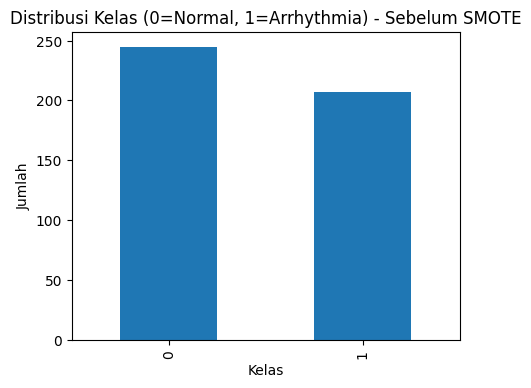

In [7]:
fig, ax = plt.subplots(figsize=(5,4))
y.value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_title("Distribusi Kelas (0=Normal, 1=Arrhythmia) - Sebelum SMOTE")
ax.set_xlabel("Kelas")
ax.set_ylabel("Jumlah")
plt.show()


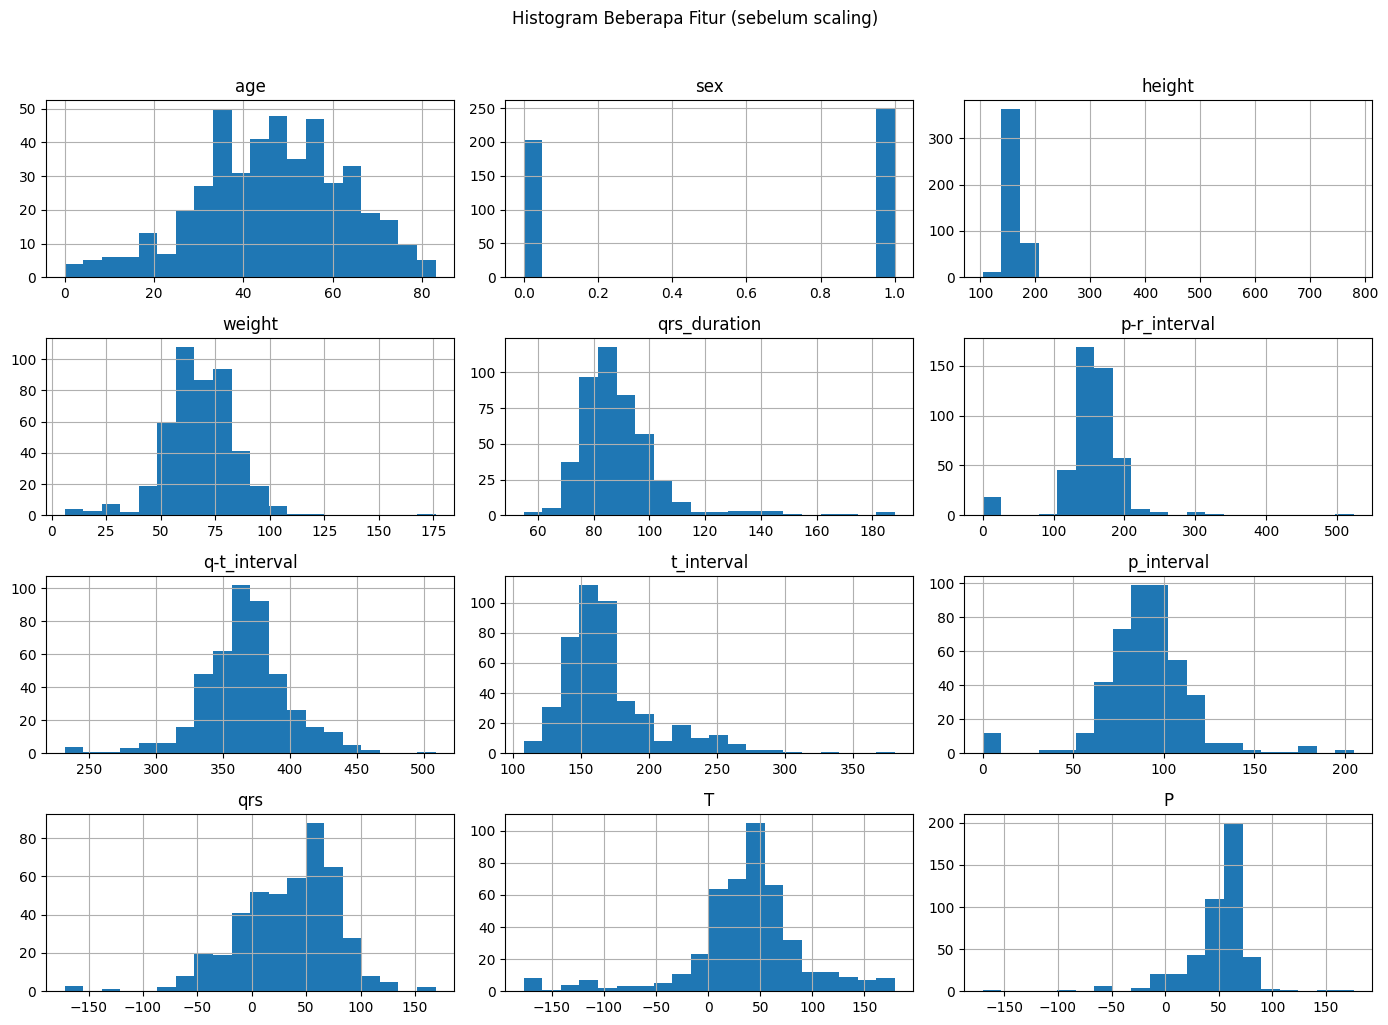

In [8]:
sample_cols = X.columns[:12]
X[sample_cols].hist(figsize=(14,10), bins=20)
plt.suptitle("Histogram Beberapa Fitur (sebelum scaling)", y=1.02)
plt.tight_layout()
plt.show()


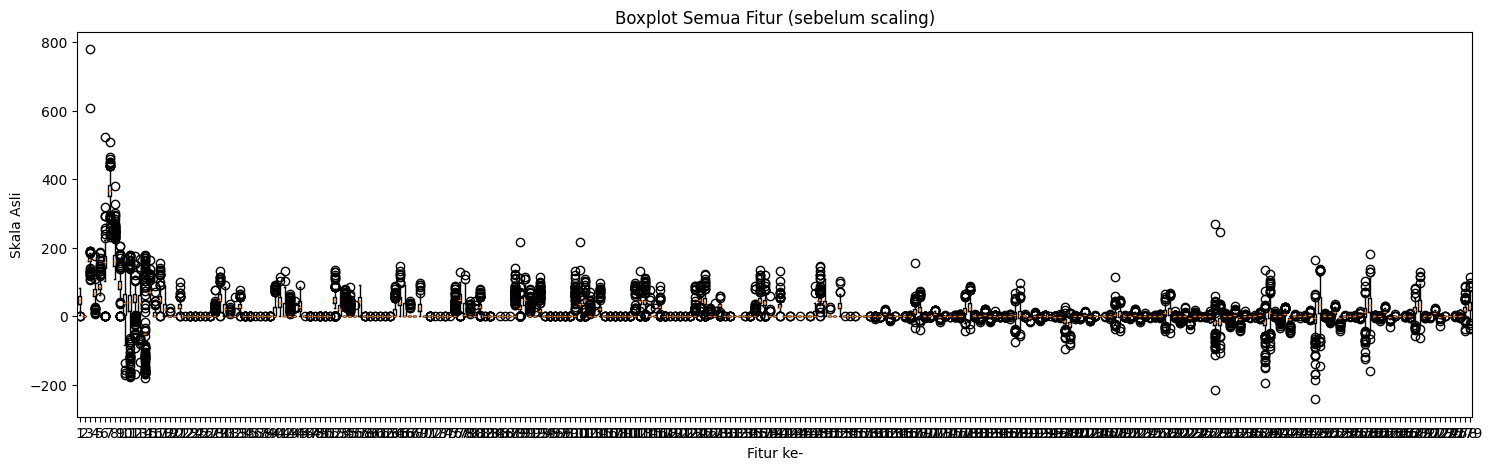

In [9]:
plt.figure(figsize=(18,5))
plt.boxplot(X.values, showfliers=True)
plt.title("Boxplot Semua Fitur (sebelum scaling)")
plt.xlabel("Fitur ke-")
plt.ylabel("Skala Asli")
plt.show()


## Load and Prepare Data

### Subtask:
Load the dataset into a pandas DataFrame, separating features (X) and target (y). Then, split the data into training and testing sets, and apply MinMaxScaler to scale the features. Data Train 80%, Data Testing 20%


**Reasoning**:
The subtask requires splitting the data into training and testing sets, then scaling the features using MinMaxScaler. I will perform these operations in a single code block.



In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data splitting and scaling complete.")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

Data splitting and scaling complete.
X_train_scaled shape: (361, 279)
X_test_scaled shape: (91, 279)


## Exploratory Data Analysis (EDA)

### Subtask:
Perform exploratory data analysis by visualizing the distribution of the 'diagnosis' column using the specified counts.


**Reasoning**:
I will create a dictionary with the specified diagnosis counts and then use `seaborn.barplot` to visualize the distribution, labeling the axes and adding a title as instructed.



/tmp/ipython-input-657685082.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_diagnosis.index, y=df_diagnosis.values, palette='viridis')


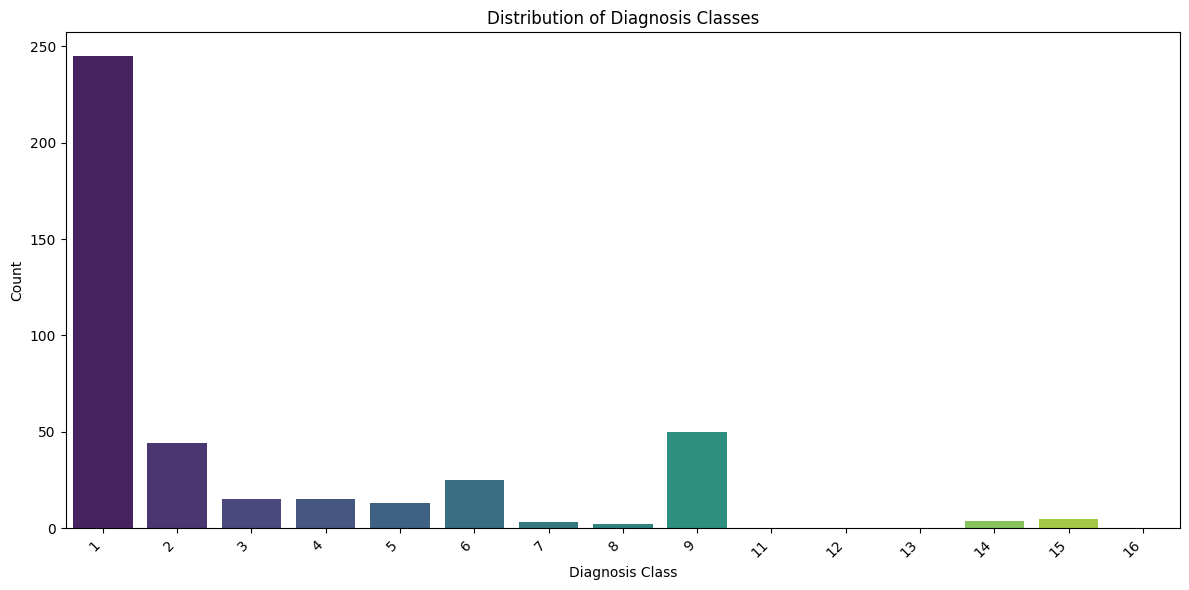

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

diagnosis_counts = {
    1: 245, 2: 44, 3: 15, 4: 15, 5: 13, 6: 25, 7: 3, 8: 2, 9: 50,
    11: 0, 12: 0, 13: 0, 14: 4, 15: 5, 16: 0
}

df_diagnosis = pd.Series(diagnosis_counts).sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=df_diagnosis.index, y=df_diagnosis.values, palette='viridis')
plt.title('Distribution of Diagnosis Classes')
plt.xlabel('Diagnosis Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Reasoning**:
The previous code generated a `FutureWarning` regarding the `palette` argument without `hue`. To address this, I will explicitly set `hue` to the same variable as `x` and set `legend=False` in the `sns.barplot` function, as suggested by the warning.



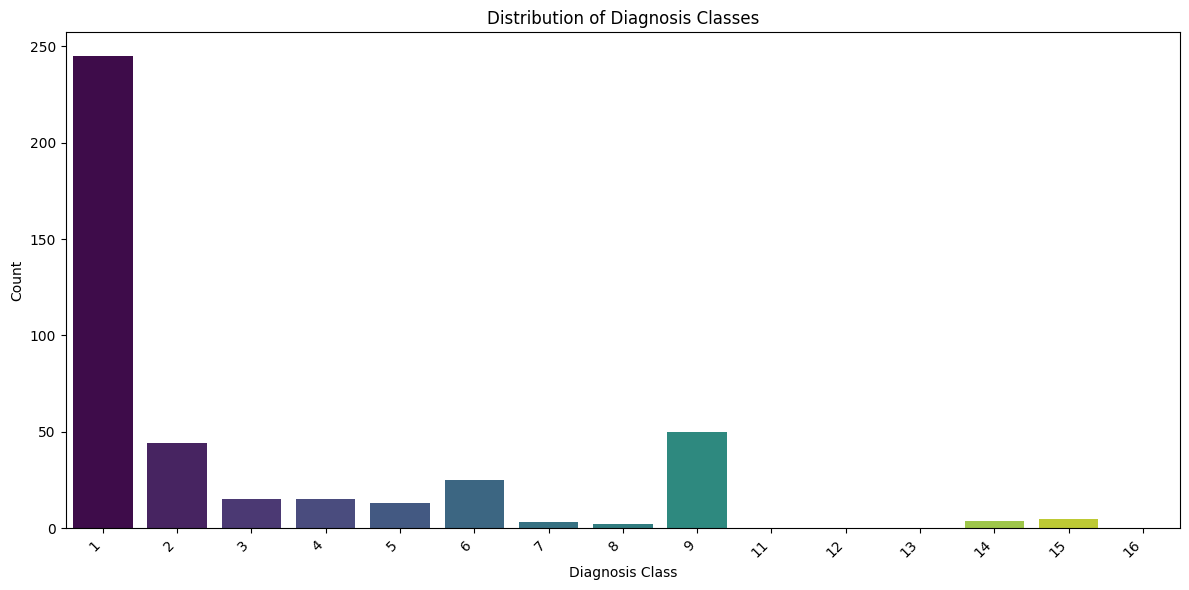

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

diagnosis_counts = {
    1: 245, 2: 44, 3: 15, 4: 15, 5: 13, 6: 25, 7: 3, 8: 2, 9: 50,
    11: 0, 12: 0, 13: 0, 14: 4, 15: 5, 16: 0
}

df_diagnosis = pd.Series(diagnosis_counts).sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=df_diagnosis.index, y=df_diagnosis.values, hue=df_diagnosis.index, palette='viridis', legend=False)
plt.title('Distribution of Diagnosis Classes')
plt.xlabel('Diagnosis Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Perform Feature Selection with RFE and XGBoost

### Subtask:
Initialize an XGBoost classifier and use Recursive Feature Elimination (RFE) to select the most important features from the scaled training data.


**Reasoning**:
I will initialize an XGBoost classifier, then use Recursive Feature Elimination (RFE) to select the most important features from the scaled training data, and finally print the number of selected features.



In [14]:
import xgboost as xgb

# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Initialize RFE with XGBoost as estimator and select 100 features
rfe_selector = RFE(estimator=xgb_model, n_features_to_select=100, step=1)

# Fit RFE to scaled training data
rfe_selector.fit(X_train_scaled, y_train)

# Transform the data to include only selected features
X_train_selected = X_train_scaled[:, rfe_selector.support_]
X_test_selected = X_test_scaled[:, rfe_selector.support_]

print(f"Number of selected features: {X_train_selected.shape[1]}")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [07:24:48] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [07:24:48] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [07:24:49] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [07:24:49] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:

Number of selected features: 100


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [07:25:49] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


**Reasoning**:
The previous output showed a `UserWarning` regarding the deprecated parameter `use_label_encoder`. To address this, I will remove `use_label_encoder=False` from the `XGBClassifier` initialization, as it is no longer needed in newer versions of XGBoost.



In [15]:
import xgboost as xgb

# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

# Initialize RFE with XGBoost as estimator and select 100 features
rfe_selector = RFE(estimator=xgb_model, n_features_to_select=100, step=1)

# Fit RFE to scaled training data
rfe_selector.fit(X_train_scaled, y_train)

# Transform the data to include only selected features
X_train_selected = X_train_scaled[:, rfe_selector.support_]
X_test_selected = X_test_scaled[:, rfe_selector.support_]

print(f"Number of selected features: {X_train_selected.shape[1]}")

Number of selected features: 100


## Train XGBoost Model

### Subtask:
Train the XGBoost classifier using the features selected by RFE from the training data.


**Reasoning**:
I will fit the previously initialized XGBoost classifier (`xgb_model`) using the RFE-selected training features (`X_train_selected`) and the training target variable (`y_train`) to train the model.



In [16]:
xgb_model.fit(X_train_selected, y_train)
print("XGBoost model trained successfully using selected features.")

XGBoost model trained successfully using selected features.


## Evaluate Model Performance

### Subtask:
Evaluate the trained XGBoost model on the test data using various metrics like accuracy, precision, recall, f1-score, and generate a classification report and confusion matrix.


**Reasoning**:
I will make predictions on the test data using the trained XGBoost model and then calculate and print various classification metrics including accuracy, precision, recall, F1-score, the classification report, and the confusion matrix.



In [17]:
y_pred = xgb_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8571
Precision: 0.8919
Recall: 0.7857
F1-score: 0.8354

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87        49
           1       0.89      0.79      0.84        42

    accuracy                           0.86        91
   macro avg       0.86      0.85      0.85        91
weighted avg       0.86      0.86      0.86        91


Confusion Matrix:
[[45  4]
 [ 9 33]]


## Visualize Confusion Matrix or Feature Importance

### Subtask:
Visualize the confusion matrix of the trained XGBoost model.

**Reasoning**:
I will visualize the confusion matrix calculated in the previous step using a heatmap for better readability and insight into the model's performance.



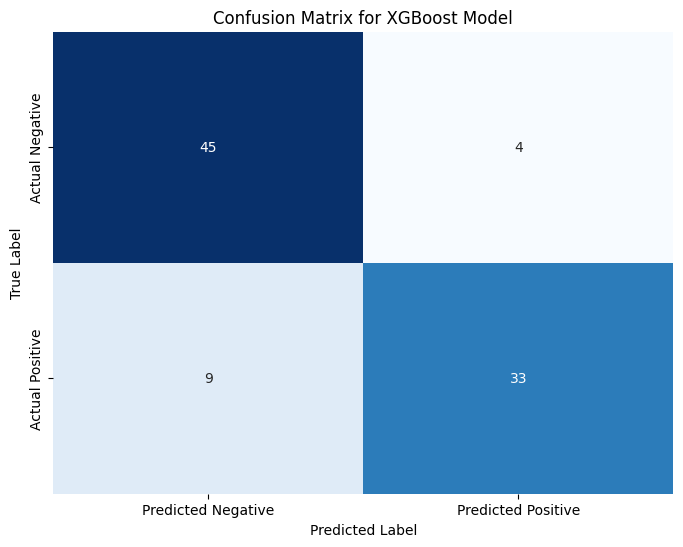

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix for XGBoost Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Summarize Findings

### Subtask:
Summarize the key findings from the model training and evaluation.

## Summarize Findings

### Subtask:
Summarize the key findings from the model training and evaluation.

### Summary of Findings

The XGBoost model, after feature selection using RFE, demonstrated good performance in detecting arrhythmia. Here are the key findings:

*   **Accuracy**: The model achieved an accuracy of **85.71%**, indicating that it correctly classified 85.71% of the total cases.
*   **Precision**: A precision of **89.19%** for the positive class (arrhythmia) means that when the model predicts arrhythmia, it is correct about 89.19% of the time.
*   **Recall**: A recall of **78.57%** for the positive class indicates that the model was able to identify 78.57% of all actual arrhythmia cases.
*   **F1-score**: The F1-score of **83.54%** provides a balanced measure between precision and recall, suggesting a robust performance.

**Confusion Matrix Analysis:**

*   **True Negatives (TN): 45** - The model correctly identified 45 normal cases.
*   **False Positives (FP): 4** - The model incorrectly classified 4 normal cases as arrhythmia (Type I error).
*   **False Negatives (FN): 9** - The model incorrectly classified 9 arrhythmia cases as normal (Type II error). This is an area for potential improvement, as missing actual arrhythmia cases can be critical.
*   **True Positives (TP): 33** - The model correctly identified 33 arrhythmia cases.

Overall, the model shows strong capability in distinguishing between normal and arrhythmia cases, with a higher propensity for correctly identifying normal cases and a moderate rate of false negatives for arrhythmia detection.

## Summary:

### Data Analysis Key Findings

*   **Data Preparation**: The dataset was successfully split into training (361 samples) and testing (91 samples) sets with a 80/20 ratio. Features were scaled using `MinMaxScaler`.
*   **Diagnosis Class Distribution**: The `diagnosis` column showed a highly imbalanced distribution. Class 1 (normal) is predominant with 245 instances, followed by Class 9 with 50 instances, and Class 2 with 44 instances. Several classes (11, 12, 13, 16) have zero instances.
*   **Feature Selection**: Recursive Feature Elimination (RFE) with an XGBoost classifier selected 100 features from the initial 279 features, optimizing the input for the model.
*   **XGBoost Model Performance**:
    *   **Accuracy**: The model achieved an accuracy of 85.71%.
    *   **Precision**: For the positive class (arrhythmia), precision was 89.19%.
    *   **Recall**: For the positive class (arrhythmia), recall was 78.57%.
    *   **F1-score**: The F1-score for the positive class was 83.54%.
*   **Confusion Matrix Analysis**:
    *   **True Negatives (TN)**: 45 normal cases were correctly identified.
    *   **False Positives (FP)**: 4 normal cases were incorrectly classified as arrhythmia.
    *   **False Negatives (FN)**: 9 arrhythmia cases were incorrectly classified as normal.
    *   **True Positives (TP)**: 33 arrhythmia cases were correctly identified.

### Insights or Next Steps

*   The model shows good overall performance, but the 9 false negatives, where actual arrhythmia cases were missed, suggest a critical area for improvement, as misdiagnosing arrhythmia can have serious consequences.
*   Given the highly imbalanced nature of the `diagnosis` classes, further investigation into techniques such as oversampling (e.g., SMOTE) or undersampling, or using algorithms robust to class imbalance, could help improve the detection of minority classes and reduce false negatives.
